setup a dataset, do one fusion step, render

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from grid_fusion_pytorch.dataset import PointCloudDataset, CustomCollate
from apex import amp
import time
import sys
import os
import shutil
from tqdm.auto import tqdm
from pprint import pprint

import torch_scatter
from grid_fusion_pytorch.render import render_grids, batch_fuse_to_grid
from moviepy import editor as mpy


import sys

import warnings 
warnings.filterwarnings("ignore", category=UserWarning)  

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap_39 = torch.tensor([[188,143,143],    # master_chef_can -  0
                        [161,203,242],    # cracker_box -  1
                        [227,88,34],      # sugar_box -  2
                        [240,128,128],    # tomato_soup_can -  3
                        [247,167,0],      # mustard_bottle -  4
                        [0,191,255],      # tuna_fish_can -  5
                        [102,205,170],    # pudding_box -  6
                        [255,69,0],       # gelatin_box -  7
                        [100,68,34],      # potted_meat_can -  8
                        [243,195,0],      # banana -  9
                        [252,90,141],     # strawberry - 10
                        [154,191,89],     # apple - 11
                        [252,227,190],    # peach - 12
                        [81,59,75],       # plum - 13
                        [100,149,237],    # pitcher_base - 14
                        [137,44,22],      # bleach_cleanser - 15
                        [0,100,0],        # bowl - 16
                        [219,210,0],      # mug - 17
                        [179,68,108],     # sponge - 18
                        [41,183,0],       # spatula - 19
                        [96,78,151],      # power_drill - 20
                        [249,147,120],    # wood_block - 21
                        [205,133,63],     # scissors - 22
                        [0,255,0],        # large_marker - 23
                        [255,0,0],        # adjustable_wrench - 24
                        [255,165,0],      # flat_screwdriver - 25
                        [199,21,133],     # hammer - 26
                        [0,250,154],      # medium_clamp - 27
                        [0,103,166],      # extra_large_clamp - 28
                        [230,143,172],    # softball - 29
                        [223,255,79],     # tennis_ball - 30
                        [139,0,139],      # racquetball - 31
                        [0,136,85],       # golf_ball - 32
                        [0,0,255],        # foam_brick - 33
                        [132,132,130],    # dice - 34
                        [240,128,128],    # colored_wood_blocks - 35
                        [195,179,129],    # toy_airplane - 36
                        [0,255,255],      # rubiks_cube - 37
                        [191,0,50]])/255. # red_box - 38

In [3]:
# x and y axis probably still buggy
def get_orbit_world_cam(n_steps=100, r=1., h=0., axis='z', look_at=np.zeros(3)):
    phis = np.linspace(0, 2*np.pi, n_steps)[::-1]
    hs   = h * np.ones_like(phis)
    x = r * np.cos(phis)
    y = r * np.sin(phis)
    z = hs
    if axis == 'z':
        orbit = np.stack([x,y,z]).T
    elif axis == 'y':
        orbit = np.stack([x,z,y]).T
    elif axis == 'x':
        orbit = np.stack([z,x,y]).T
    orbit += look_at
    z_cam = (look_at - orbit)
    z_cam /= np.linalg.norm(z_cam, axis=-1, keepdims=True)
    
    x_cam = np.cross(z_cam, np.array([0., 0., -1.]))
    
    y_cam = np.cross(x_cam, z_cam)
    
    world_cam = np.zeros((n_steps, 4, 4))
    world_cam[:,:3,0] = -x_cam # maybe some bug here, image is mirrored
    world_cam[:,:3,1] = y_cam 
    world_cam[:,:3,2] = z_cam
    world_cam[:,:3,-1] = orbit
    
    world_cam[:,-1,-1] = 1
    
    world_cam_pt = torch.from_numpy(world_cam).float()
    #world_cam_pt[:,:3,:3] = world_cam_pt[:,:3,:3].permute(0,2,1)
    #world_cam_pt[:,:3,-1] = (world_cam_pt[:,:3,:3] @ world_cam_pt[:,:3,-1].unsqueeze(-1)).squeeze(-1)
    return world_cam_pt

@torch.no_grad()
def render_orbit(grids, grid_config, cam_k, scale=1., grid_idx=0, cam_idx=0, n_steps=100, r=1.5, h=0., axis='z', n_points=100, look_at=np.array([0,0,0.9]), max_chunksize=1000000):
    render_grid = grids[grid_idx:grid_idx+1]
    world_cam = get_orbit_world_cam(n_steps, r, h, axis, look_at).to(render_grid.device).unsqueeze(1)
    #for item in world_cam:
    #    print(item)
    cx = cam_k[grid_idx, cam_idx, 0, 2]
    cy = cam_k[grid_idx, cam_idx, 1, 2]
#    scale_matrix = torch.tensor([[scale, 0, 0.5*scale-0.5],
#                                 [0, scale, 0.5*scale-0.5],
#                                 [0, 0, 1]], device=render_grid.device)
    scale_matrix = torch.tensor([[scale, 0, scale],
                                 [0, scale, scale],
                                 [0, 0, 1]], device=render_grid.device)
    render_cam_k = scale_matrix[None,None] * cam_k[grid_idx:grid_idx+1, cam_idx:cam_idx+1]
    H, W = int(2*cy), int(2*cx)
    renders, renders_depth, trs = [], [], []
    for i in range(n_steps):
        r, rd, tr, _, _ = render_grids(render_grid, grid_config, world_cam[i:i+1], render_cam_k, n_points=n_points, H=H, W=W)
        renders.append(r.cpu())
        renders_depth.append(rd.cpu())
        trs.append(tr.cpu())
        del r, rd, tr
    return torch.stack(renders).squeeze().permute(0,2,1).view(n_steps,-1,H,W), torch.stack(renders_depth).squeeze().view(n_steps,H,W), torch.stack(trs).squeeze().view(n_steps,H,W)

In [4]:
MODE = 'normal'
DATASET_NAME = 'overfit_O39_S1_C32_pcd_' + MODE #'proto_refine_pcd'
NUM_CAMS = -1
BATCH_SIZE = 1
INSPECT_SHAPES = True
RANDOM_PCD = False

# create a dummy dataset and showcase dataloading
test_dataset = PointCloudDataset(root='/home/nfs/inf6/data/datasets/semantic_pcd_data/'+DATASET_NAME, split='full',
                                 num_steps=-1, num_cams=NUM_CAMS, random_pcd=RANDOM_PCD, cam_world=False)
if INSPECT_SHAPES:
    print('Length of test_dataset:', len(test_dataset), '\n')

# look at the data returned by this dataset
if INSPECT_SHAPES:
    test_output = test_dataset.__getitem__(0)
    pcd, semseg, cam_pose, depth, cam_k, gt = test_output
    print('Dataset __getitem__ output len/shapes:\n', len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape, gt.shape, '\n')
    print('pcd element shapes:')
    for item in pcd:
        print(item.shape)
    print()

# define a collate function and a dataloader
collate = CustomCollate(min_num_steps=1, max_num_steps=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
# look at the output shapes of each minibatch
if INSPECT_SHAPES:
    for pcd, semseg, cam_pose, depth, cam_k, gt in test_dataloader:
        print('Minibatch output len/shapes:\n', len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape, gt.shape)
        print('pcd batched element shapes:')
        for item in pcd:
            print(item.shape)
    print()

# example for adapting the maximum number of fusion/refinement steps
if INSPECT_SHAPES:
    test_dataloader.collate_fn.set_steps(1, 6)
    for pcd, semseg, cam_pose, depth, cam_k, gt in test_dataloader:
        print('Minibatch output len/shapes:\n', len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape, gt.shape)
        print('pcd batched element shapes:')
        for item in pcd:
            print(item.shape)

Length of test_dataset: 1 

Dataset __getitem__ output len/shapes:
 6 torch.Size([22, 1, 480, 640]) torch.Size([22, 4, 4]) torch.Size([22, 1, 480, 640]) torch.Size([22, 3, 3]) torch.Size([2122936, 42]) 

pcd element shapes:
torch.Size([188719, 42])
torch.Size([95493, 42])
torch.Size([93658, 42])
torch.Size([42648, 42])
torch.Size([212162, 42])
torch.Size([36941, 42])

Minibatch output len/shapes:
 2 torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3]) torch.Size([1, 2122936, 42])
pcd batched element shapes:
torch.Size([1, 188719, 42])
torch.Size([1, 95493, 42])

Minibatch output len/shapes:
 3 torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3]) torch.Size([1, 2122936, 42])
pcd batched element shapes:
torch.Size([1, 188719, 42])
torch.Size([1, 95493, 42])
torch.Size([1, 93658, 42])


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
dtype = torch.float32

VERBOSE = True
VIS = True
RENDER = True
N_STEPS = 3
EPS = 6e-1

#remap_cuda = remap.to(device)

voxel_grid_config = np.load('voxel_grid_config.npy', allow_pickle=True).item()

print('Channels:', voxel_grid_config['channels'])
print('World size:', voxel_grid_config['world_size'])
print('Voxel size:', voxel_grid_config['voxel_size'])
if voxel_grid_config['use_pos_enc']:
    print('Positional encoding shape:', voxel_grid_config['pos_enc'].shape)
print()

# renderer setup
N_RAYS = -1
N_POINTS = 192


##### train
best_loss = 1e25
test_dataloader.collate_fn.set_steps(N_STEPS, N_STEPS)
data_loader_items = list(iter(test_dataloader))
pcd, semseg, cam_pose, depth, cam_k, gt = data_loader_items[0]
semseg, cam_pose, depth, cam_k = semseg.to(device), cam_pose.to(device), depth.to(device), cam_k.to(device)
#semseg = remap_cuda[semseg]
if VERBOSE:
    print('DATA LOADING')
    print('Minibatch output len/shapes\n', 'len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape')
    print(len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape)
    print()

##### FUSION STEP
if VERBOSE:
    print('FUSION STEP')
grid_batch = None
grid_batch_refined = None
for k, point_cloud_batch in enumerate(pcd[-1:]):
    if VERBOSE:
        print('Point cloud batch shape:', point_cloud_batch.shape)
    # fuse voxels
    with torch.no_grad():
        grid_batch = batch_fuse_to_grid(point_cloud_batch.to(device), grid_batch,
                                        world_size=voxel_grid_config['world_size'],
                                        channels=voxel_grid_config['channels'],
                                        range_min=voxel_grid_config['range_min'],
                                        range_max=voxel_grid_config['range_max'],
                                        density_step=voxel_grid_config['density_factor']*voxel_grid_config['voxel_size'])
with torch.no_grad():
    # switch to probabilities
    grid_batch_unrefined = torch.cat([grid_batch[:,:1], torch.exp(grid_batch[:,1:-1]), grid_batch[:,-1:]], dim=1)

print('Grid shapes:', grid_batch.shape, grid_batch_unrefined.shape)

Using device: cuda
Channels: 39
World size: tensor([140, 112, 100])
Voxel size: tensor(0.0101)

DATA LOADING
Minibatch output len/shapes
 len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape
3 torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3])

FUSION STEP
Point cloud batch shape: torch.Size([1, 93658, 42])
Grid shapes: torch.Size([1, 41, 140, 112, 100]) torch.Size([1, 41, 140, 112, 100])


renders, renders_depth, trs = render_orbit(grid_batch_unrefined.half(), voxel_grid_config, cam_k,  
                                           r=0.9, h=1., n_steps=300, n_points=N_POINTS, axis='z', 
                                           look_at=np.array([0,0,0.92]), max_chunksize=100000000)

render_vis = cmap_39[renders.argmax(1).squeeze()]

background_render = torch.abs(trs - 1) <= 0

render_vis[background_render] = torch.zeros(3).to(render_vis.device)

render_vis_np = (255*render_vis).byte().numpy()

clip = mpy.ImageSequenceClip([item for item in render_vis_np], fps=30)

clip.ipython_display()

In [6]:
semseg_dummy, cam_pose_dummy, depth_dummy, cam_k_dummy = semseg[:,:2], cam_pose[:,:2], depth[:,:2], cam_k[:,:2]
print('Dummy input shapes:', semseg_dummy.shape, cam_pose_dummy.shape, depth_dummy.shape, cam_k_dummy.shape)

# TODO N_SCENES = ... and then stack these dummy objects accordingly

B = depth_dummy.shape[0]
H, W, D = 140, 112, 100
n_misses = torch.zeros([B, H, W, D]).to(device)
print('Miss counter shape:', n_misses.shape)

Dummy input shapes: torch.Size([1, 2, 1, 480, 640]) torch.Size([1, 2, 4, 4]) torch.Size([1, 2, 1, 480, 640]) torch.Size([1, 2, 3, 3])
Miss counter shape: torch.Size([1, 140, 112, 100])


In [7]:
from grid_fusion_pytorch.render import sample_rays

ray_origs, ray_dirs, semseg_out, depth_out = sample_rays(cam_pose_dummy, cam_k_dummy, depth=depth_dummy)
depth_out = depth_out.squeeze(-1)
range_max, range_min = voxel_grid_config['range_max'][:3].to(device), voxel_grid_config['range_min'][:3].to(device)
print(ray_origs.shape, ray_dirs.shape, semseg_out, depth_out.shape, range_min.shape, range_max.shape)

torch.Size([1, 2, 3]) torch.Size([1, 2, 307200, 3]) None torch.Size([1, 2, 307200]) torch.Size([3]) torch.Size([3])


In [8]:
from lib.module_name import increment_misses

out = increment_misses(n_misses, ray_origs, ray_dirs, depth_out, range_min, range_max)
print(out.shape)

Using /home/nogga/.cache/torch_extensions/py38_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/nogga/.cache/torch_extensions/py38_cu118/increment_misses_util_cuda/build.ninja...
Building extension module increment_misses_util_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
torch.Size([1, 140, 112, 100])


Loading extension module increment_misses_util_cuda...


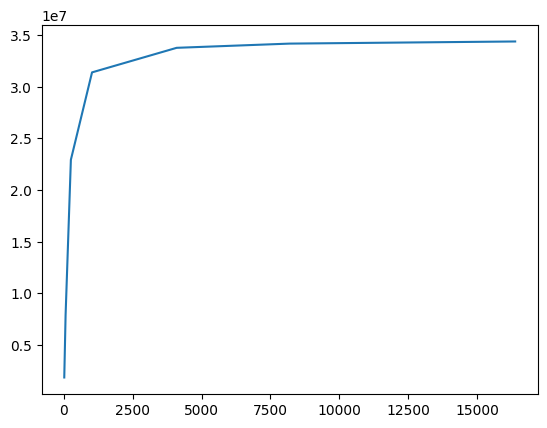

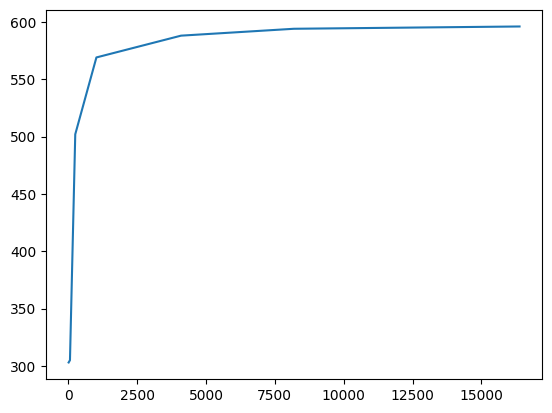

In [12]:
sum_hist, max_hist = [], []
n_steps = np.array([16, 64, 256, 1024, 4096, 8192, 16384])
for steps in n_steps:
    out = increment_misses(n_misses, ray_origs, ray_dirs, depth_out, range_min, range_max, n_steps=steps)
    sum_hist.append(out.sum().cpu().item())
    max_hist.append(out.max().cpu().item())
plt.plot(n_steps, np.array(sum_hist))
plt.show()
plt.plot(n_steps, np.array(max_hist))
plt.show()

In [10]:
print(n_misses.sum())
print(out.sum(), out.min(), out.max())

tensor(0., device='cuda:0')
tensor(34175000., device='cuda:0') tensor(0., device='cuda:0') tensor(594., device='cuda:0')


In [11]:
# TODO - check if sample_rays generalizes to more than one scene
# TODO - implement hit counter and Bayes filter in the same cuda kernel